In [2]:
'''
Simulation Code
Written by Wolfgang Ridinger and Chaitanya Baweja
Dependencies:
Mention Files
'''

'\nSimulation Code\nWritten by Wolfgang Ridinger and Chaitanya Baweja\nDependencies:\nMention Files\n'

In [44]:
import numpy as np
#from scipy import interpolate
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize
from bayes_opt import BayesianOptimization
import time
import argparse
%run car_auctions_jupyter.py


In [4]:
#Setting notebook parameters
np.random.seed(2)

# use sklearn's default parameters for theta and random_start
gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 2}

#%load_ext autotime

%matplotlib inline

In [5]:

##
# Grids
##

#y_grid basically denote individual wealth levels
#We create a grid so that we can find an approximate function
y_grid = 100000 + 5000*np.arange(400)
#required for use in functions
y_grid = y_grid.reshape(400)

#b_grid denotes
b_grid = 20000 + 5000*np.arange(0,600)

lyg = len(y_grid) 

#lbg = len(b_grid)


In [6]:

##
# Parameters
##
#Why is parameter of beta set to 0.95 
beta = 0.95 #discount factor
alpha = 10 #parameter for value function
#Check if w is required later on
w = np.array([1,2,4])
#better way
param = np.array([alpha,1,2,4])
J = len(w)
#what is rho
rho = np.ones(np.shape(w))/np.shape(w)
#should cars be picked at random or based on seller interest, won't it based on seller conditions
sigma=0.1 #probability of a seller being picked
n_draws = 200
#WHat is N
N = 100
#b = 0.1


# States

In [7]:
#import stock market level
df=pd.read_csv("simulation_data/avgsp.csv", sep=",")
state_grid = 200.0*np.arange(2,11)
lsg = len(state_grid)

#assign states to S&P Data

#round S&P level to nearest grid point
df['state'] = [400+200*np.round((sp-400)/200,0) for sp in df['avgsp']]

#calculate return
df['return'] = [df['avgsp'][i+1]/df['avgsp'][i] for i in range(len(df)-1)] + ['NA']

df

,Unnamed: 0,season,avgsp,state,return
0,1,1992,448.303753,400.0,1.02887
1,2,1993,461.245832,400.0,1.08824
2,3,1994,501.945005,600.0,1.26093
3,4,1995,632.918330,600.0,1.2657
4,5,1996,801.083338,800.0,1.283
5,6,1997,1027.788335,1000.0,1.21391
6,7,1998,1247.644999,1200.0,1.1381
7,8,1999,1419.950002,1400.0,0.900377
8,9,2000,1278.490814,1200.0,0.830024
9,10,2001,1061.178324,1000.0,0.857186


## Transition Probabilities between States

For now assume transition probabilities according to relative frequency of each state, regardless of current state (conditional and unconditional probabilities are the same)

In [8]:
state_freq = np.array([np.sum(1*(df['state']==s))/(len(df)-1.00) for s in state_grid])
transition_probs = np.tile(state_freq,lsg).reshape(lsg,lsg)

## Distribution of Returns by State

For now assume expectations over returns are the same in all states.

In [9]:
#Realised returns in S&P Data
realis_sp_return = np.array([df['avgsp'][i+1]/df['avgsp'][i] for i in range(len(df)-1)])

#Individual Returns: one of the realised returns plus idiosyncratic noise
np.random.seed(3)
distr_mean_R = np.array(np.random.choice(realis_sp_return,size=n_draws,replace=True))
np.random.seed(2)
#question: is it a good idea to add uniform idiosyncratic noise, rather than a normal one 
distr_R = distr_mean_R + np.random.uniform(-0.05,+0.05,n_draws)

distr_R_states = np.array([distr_R for s in state_grid])
#distr_R_states

In [10]:
np.mean(distr_R)

1.0819433751865255

## Income Distribution by State

In [11]:
np.random.seed(2)
#why is this required
y_realis_1 = np.random.lognormal(np.log(150000),np.log(2),np.round(N))

state_grid_change = np.array([state_grid[i]/state_grid[0] for i in range(lsg)])

#mean wealth
#50% of wealth invested in the stock market
#This is very weird implementation, this actually might be an error 
mean_wealth_state = np.array([75000 + state_grid_change[s]*75000 for s in range(lsg)])
np.random.seed(4)
y_realis_states = np.array([np.random.lognormal(np.log(mean_wealth_state[s]),np.log(2),np.round(N)) for s in range(lsg)])



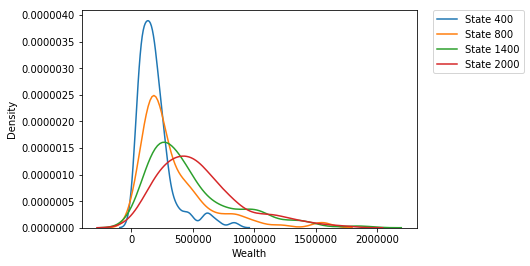

In [12]:
fig, ax = plt.subplots()
for s in [0,2,5,8]: sns.distplot(y_realis_states[s,:],hist=False, label="State %d" %state_grid[s])
ax.set_xlabel("Wealth")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Bid Function

$b_j(y,s) = \theta y (w_j + \beta(\textbf{E}[S_j(y',s') | y-b_j(y,s),s] - \textbf{E}[B(y',s') | y,s] ))$

# Buyer Value Function

\begin{align*}
  B_{j}(y,s) =& \alpha \text{ln}((1-\beta) y) + (1-\sigma \textbf{Pr}[b_j(y,s)>\bar{b}_j])\cdot \beta \textbf{E}[B(y',s') | y,s] +\\
  &\sigma \cdot \int \Big( \textbf{1}(b_j(y,s)>\bar{b}_j) \big(w_j - \frac{\theta}{y} \bar{b}_j + \beta  \textbf{E}[S_j(y',s') | y-\bar{b}_j,s] \big) \Big) dG_{\bar{b}_j |s} \\
\end{align*}



# Seller Value Function

\begin{align*}
  S_{j}(y,s) =& \alpha \text{ln}((1-\beta) y) + (1-\rho_j)\cdot(w_j + \beta \textbf{E}[S_j(y',s') | y,s] ) + \\
  & \rho_j \cdot \int \Big( \text{max}\{ \frac{\theta}{y} b_{j,(2)} + \textbf{E}[B(y',s') | y+b_{j,(2)},s] ,\ w_j + \beta \textbf{E}[S_j(y',s') | y,s] \} \Big) dH_{b_{j,(2)} |s}
\end{align*}



## ------------------------------------------------------------------------------------
## New Approach
## ------------------------------------------------------------------------------------

Interpolate EB and ES in addition to interpolate B and S. Saves time by saving on many MC integrations.

In [45]:
B1 = (1/(1-beta))*  (alpha*np.log((1-beta)*y_grid) + np.zeros(len(w)*state_grid.shape[0]*len(y_grid)).reshape(len(w),state_grid.shape[0],len(y_grid)))
S1 = (1/(1-beta))* (alpha*np.log((1-beta)*y_grid) + np.array(np.repeat(w,state_grid.shape[0]*len(y_grid))).reshape(len(w),state_grid.shape[0],len(y_grid)))
B1_interp = np.array([[interp1d(y_grid,B1[j,s,:],kind='linear',fill_value='extrapolate') for s in np.arange(lsg)] for j in np.arange(J)])
S1_interp = np.array([[interp1d(y_grid,S1[j,s,:],kind='linear',fill_value='extrapolate') for s in np.arange(lsg)] for j in np.arange(J)])

param1 = [beta,rho,w,J,alpha,sigma]
set1 = [y_grid,lyg,b_grid,n_draws,state_grid]

car_auctions = CarAuction()
car_auctions.error(B1_interp, S1_interp)

53016751.85732199
52976653.93685736
52939852.5973761
52968672.0819136
53040037.99999995
53014033.194257244
53037654.09471213
52972242.41593794
53022563.15541237
53002008.18480337
53034207.13501303
53039452.340219036
53036633.83721818
52996720.31030106
52958470.816190906
52990511.841114864
52950035.82055953
53018789.81017157
53014514.33448783
53029860.06456814
52958996.27382174
52981772.309134156
53037641.48421404
52982384.04231587
52983605.89748244
52945585.34932559
52968802.924360886


NameError: name 'f' is not defined

Wall time: 7min 30s


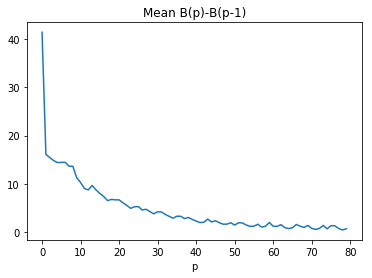

In [30]:
%%time
np.random.seed(2)

#initial value functions
B_cont = (1/(1-beta))*  (alpha*np.log((1-beta)*y_grid) + np.zeros(len(w)*state_grid.shape[0]*len(y_grid)).reshape(len(w),state_grid.shape[0],len(y_grid)))
S_cont = (1/(1-beta))* (alpha*np.log((1-beta)*y_grid) + np.array(np.repeat(w,state_grid.shape[0]*len(y_grid))).reshape(len(w),state_grid.shape[0],len(y_grid)))

#every one of N potential bidders has probability sigma of being active -- if m bidders are active, there are m-1 rivals
rival_bidders = np.random.binomial(N,sigma,size=n_draws) - 1
rival_bidders_ids = np.array([np.random.choice(N,size=rival_bidders[i], replace=False) for i in np.arange(n_draws)]) #dimensions: n_draws

#every one of N potential bidders has probability sigma of being active
active_bidders = np.random.binomial(N,sigma,size=n_draws)
active_bidders_ids = np.array([np.random.choice(N,size=active_bidders[i], replace=False) for i in np.arange(n_draws)])
#dimensions: n_draws

#param_1 = [alpha,w]
'''
param_1 =[7.8,np.array([8.3,3.4,2.2])]
param_2 = [beta,rho,sigma]
set1 = [y_grid,lyg,b_grid,n_draws,state_grid]   
'''
car_auctions = CarAuction()
car_auctions.error()

for deg in[1]:
    sim_output = car_auctions.fn_iterate(B_start = B_cont,S_start = S_cont, n_iter = 80,
                            f_distr_R_states = distr_R_states,f_transition_probs = transition_probs,
                            f_y_realis = y_realis_states,
                            f_rival_bidders_ids=rival_bidders_ids, f_active_bidders_ids = active_bidders_ids, deg=deg)
    check_mean = [np.mean(c) for c in sim_output[0]]
    fig, ax = plt.subplots()
    ax.plot(range(len(check_mean)),check_mean)
    ax.set_xlabel("p")
    plt.title("Mean B(p)-B(p-1)")

In [ ]:

%%time
np.random.seed(2)

#initial value functions
B_cont = (1/(1-beta))*  (alpha*np.log((1-beta)*y_grid) + np.zeros(len(w)*state_grid.shape[0]*len(y_grid)).reshape(len(w),state_grid.shape[0],len(y_grid)))
S_cont = (1/(1-beta))* (alpha*np.log((1-beta)*y_grid) + np.array(np.repeat(w,state_grid.shape[0]*len(y_grid))).reshape(len(w),state_grid.shape[0],len(y_grid)))

#every one of N potential bidders has probability sigma of being active -- if m bidders are active, there are m-1 rivals
rival_bidders = np.random.binomial(N,sigma,size=n_draws) - 1
rival_bidders_ids = np.array([np.random.choice(N,size=rival_bidders[i], replace=False) for i in np.arange(n_draws)]) #dimensions: n_draws

#every one of N potential bidders has probability sigma of being active
active_bidders = np.random.binomial(N,sigma,size=n_draws)
active_bidders_ids = np.array([np.random.choice(N,size=active_bidders[i], replace=False) for i in np.arange(n_draws)])
#dimensions: n_draws

param_1 = [alpha,w]
param_2 = [beta,rho,sigma]
set1 = [y_grid,lyg,b_grid,n_draws,state_grid]    

sim_output = fn_iterate(f_param1 = param_1,f_param2 = param_2,f_set = set1,
                    B_start = B_cont,S_start = S_cont, n_iter = 80,
                    f_distr_R_states = distr_R_states,f_transition_probs = transition_probs,
                    f_y_realis = y_realis_states,
                    f_rival_bidders_ids=rival_bidders_ids, f_active_bidders_ids = active_bidders_ids,deg=5)

#check,bids_iter,B1,S1

In [ ]:
check_mean = [np.mean(c) for c in sim_output[0]]

fig, ax = plt.subplots()
ax.plot(range(len(check_mean)),check_mean)
ax.set_xlabel("p")
plt.title("Mean B(p)-B(p-1)")

In [ ]:
check_max = [np.max(c) for c in sim_output[0]]

fig, ax = plt.subplots()
ax.plot(range(len(check_max)),check_max)
ax.set_xlabel("p")
plt.title("Max B(p)-B(p-1)")

In [ ]:
fig, ax = plt.subplots()
for p in [20,30,40,50,60,70,79]:
    ax.plot(y_grid,sim_output[2][p][1,4,:], label="Buyer state 4 p=%d" %p)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Final Bid Function
sim_bid_function = sim_output[1][79]

In [ ]:
fig, ax = plt.subplots()
#ax.plot(y_grid,y_grid, label="y")
for j in [0,1,2]:
    ax.plot(y_grid,sim_bid_function[j,4,:], label="$b_%d(y,0)" %j)
#for j in [1,2]:
#    ax.plot(y_grid,sim_output[1][1][j,4,:], label="$b_%d(y,8)" %j)
#for j in [1,2]:
#    ax.plot(y_grid,sim_output[1][1][j,8,:], label="$b_%d(y,8)" %j)
ax.set_xlabel("Wealth")
ax.set_ylabel("Bid")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Prices by states and cars
sim_distr_bids = np.array([[np.interp(y_realis_states[s,:],y_grid,sim_bid_function[j,s,:]) for s in np.arange(lsg)] for j in np.arange(J)])
sim_distr_b_2 = np.array([[[np.sort(sim_distr_bids[j,s,active_bidders_ids[i]])[-2] for i in np.arange(n_draws)] for s in np.arange(lsg)] for j in np.arange(J)])

sim_exp_price = np.mean(sim_distr_b_2,axis=2)


In [ ]:
# Simulate prices over years by interpolating to S&P500 in respective year
time_prices = np.array([interp1d(state_grid,sim_exp_price[j,:], fill_value='extrapolate')(df['avgsp']) for j in range(J)])

In [ ]:
#plt.plot(range(1992,2017),time_prices[1,:])

fig, ax = plt.subplots()
for j in [0,1,2]:
    ax.plot(range(1992,2017),time_prices[j,:], label="Car %d" %j)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Simulated Expected Prices")


In [ ]:
fig, ax = plt.subplots()
for j in [0,1,2]:
    ax.plot(range(1992,2017),np.log(time_prices[j,:]/time_prices[j,16]), label="Car %d" %j)
ax.plot(range(1992,2017),np.log(df['avgsp']/df['avgsp'][16]), label="Average S&P500")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Log Prices vs Log S&P500")


In [ ]:
#calculate average over J
avg_time_prices = np.mean(time_prices, axis=0)

avg_time_prices.shape
df['avgsp'].shape

np.corrcoef(avg_time_prices,df['avgsp'])[0][1]


In [ ]:
df_prices=pd.read_csv("simulation_data/book_total_brands.csv", sep=",")

In [ ]:
fig, ax = plt.subplots()
for j in [0,1,2]:
    ax.plot(range(1992,2017),np.log(time_prices[j,:]/time_prices[j,16]), label="Car %d" %j)
#ax.plot(range(1992,2017),np.log(df['avgsp']/df['avgsp'][16]), label="Average S&P500")
ax.plot(range(1993,2016),np.log(df_prices['avg_value_USD']/df_prices['avg_value_USD'][15]), label="Cars Data", color="black")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Simulated Log Prices vs Data")





In [ ]:
#correlate data with S&P500
np.corrcoef(df_prices['avg_value_USD'],df['avgsp'][1:24])

#len(df_prices['avg_value_USD'].values)
#len(df['avgsp'].values)

#df[1:24]

In [ ]:
df_prices

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1993,2016),np.log(df_prices['avg_value_USD']/df_prices['avg_value_USD'][15]), label="Avg Price Data", color="black")
ax.plot(range(1993,2016),np.log(df_prices['avg_ferrari']/df_prices['avg_ferrari'][15]), label="Ferrari", color="red")
ax.plot(range(1993,2016),np.log(df_prices['avg_mercedes']/df_prices['avg_mercedes'][15]), label="Mercedes", color="blue")
ax.plot(range(1993,2016),np.log(df_prices['avg_porsche']/df_prices['avg_porsche'][15]), label="Porsche", color="green")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)